In [1]:
import moviepy
from moviepy.video.VideoClip import ImageClip
from moviepy.editor import VideoFileClip, concatenate_videoclips, ipython_display
from PIL import Image, ImageChops
import numpy as np
from os.path import join as opj
from collections import OrderedDict
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
from movie_tools import mix_frames, scroll_im_frames, supplement_ims, add_scroll_to_text, color_mix_frames, g_to_mono, get_sub_images
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import HTML
from PIL import ImageOps, ImageChops, ImageEnhance
import skimage.measure as measure
from skimage import io, color
import skimage.morphology as morph
from skimage.filters import threshold_otsu
from moviepy.video import VideoClip
from moviepy.editor import AudioFileClip, concatenate_audioclips, vfx, CompositeAudioClip, concatenate_videoclips


In [116]:
def get_animation(frames, interval=100, downsample=None):
    fig,ax=plt.subplots()
    display_im=ax.imshow(frames[0])
    ax.axis("off")
    plt.close()
    
    def init():
        display_im.set_data(frames[0])
    
    def animate(i):
        if downsample:
            im = frames[i].copy()
            new_size = (int(float(im.size[0])/downsample+0.5),
                        int(float(im.size[1])/downsample+0.5)
                       )
            if i==0:
                print("downsampling from %s to %s"%(str(im.size), str(new_size)))
            im=im.resize(new_size)
        else:
            im = frames[i]
        display_im.set_data(im)
    
    return animation.FuncAnimation(fig, animate, init_func=init, frames=len(frames), interval=interval)

def get_sub_image(frac_left, frac_bottom, size_frac_y, size_out, im, verbose=False):
    if isinstance(im, str):
        im = Image.open(im)
    orig_size = im.size
    if verbose:
        print("orig_size:",orig_size)
    left = int(frac_left*orig_size[0]+0.5)
    bottom = int(frac_bottom*orig_size[1]+0.5)
    dy = size_frac_y*orig_size[1]
    top = bottom + int(dy+0.5)
    dx = dy * float(size_out[0])/size_out[1]
    right = left + int(dx+0.5)

    box = [left,bottom,right,top]
    if verbose:
        print("box:",box)
    im_cropped = im.crop(tuple(box))
    
    return im_cropped.resize(size_out,resample=Image.LANCZOS)
    
#get sub-images
def get_sub_images(frac_left, frac_bottom, size_frac_y, size_out, ims, verbose=False, convert=None):
    ims_out = []
    for im in ims:
        if isinstance(im, str):
            im = Image.open(im)
            if convert:
                im = im.convert("L")
        orig_size = im.size
        if verbose:
            print("orig_size:",orig_size)
        left = int(frac_left*orig_size[0]+0.5)
        bottom = int(frac_bottom*orig_size[1]+0.5)
        dy = size_frac_y*orig_size[1]
        top = bottom + int(dy+0.5)
        dx = dy * float(size_out[0])/size_out[1]
        right = left + int(dx+0.5)

        box = [left,bottom,right,top]
        if verbose:
            print("box:",box)
        im_cropped = im.crop(tuple(box))
        ims_out.append(
            im_cropped.resize(size_out,resample=Image.LANCZOS)
        )
    return ims_out



def flicker_marks(im, num_frames, thresh_mult=1.7, alpha_min=10, add_alpha=False):
    thresh = threshold_otsu(np.asarray(im))
    im_grey = (im.copy()).convert("L")
    im_grey_inverted = ImageOps.invert(im_grey.copy())
    im_thresh = (np.asarray(im_grey_inverted) > thresh*thresh_mult)
    Strel = morph.disk(2)
    im_thresh = morph.dilation(im_thresh,Strel)

    label_img = measure.label(im_thresh)
    print("label_img.shape:", label_img.shape)
    #now we've got the labels, we just want to turn on and off
    #marks at random
    num_labels = label_img.max()
    print("num_labels:",num_labels)
    labels = np.arange(1, num_labels+1)
    frames_out = []
    for i in range(num_frames):
        alpha_vals = (255*np.random.random(len(labels))).astype(int)
        im_new = im_grey.copy()
        #Might be easiest to do this with alpha channel
        alpha = 10*np.ones(im_grey.size).astype(np.uint8).T
        for label,alpha_val in zip(labels, alpha_vals):
            alpha[np.where(label_img==label)] = alpha_val
        alpha_im = Image.fromarray(alpha)
        if add_alpha:
            im_new.putalpha(alpha_im)
        else:
            alpha_frac = alpha.astype(float)/255
            im_new_array = np.round( (1-alpha_frac)*255 + alpha_frac*np.array(im_grey.copy()) ).astype(np.uint8)
            im_new = Image.fromarray(im_new_array)
            
        frames_out.append(im_new)
        
    return frames_out, label_img

def reverse_loop_frames(frames, n):
    rev_frames = frames[::-1]
    frames_out=[]
    for i in range(n):
        frames_out += frames
        frames_out += rev_frames[1:-1]
    return frames_out


def lighten_im(im, lighten_fac):
    im_array = np.array(im)
    if im.mode=="RGB":
        im_array_out = np.zeros_like(im_array)
        for i,channel in enumerate(im_array):
            im_array_out[i] = np.round((1-lighten_fac)*255 + lighten_fac*im_array[i]).astype(np.uint8)
        return Image.fromarray(im_array_out)
    elif im.mode=="L":
        im_array_out = np.round((1-lighten_fac)*255 + lighten_fac*im_array).astype(np.uint8)
        return Image.fromarray(im_array_out)

def come_in_and_fade_out(im, num_frames):
    frames = []
    lighten_facs = np.linspace(1., 0., num_frames)
    print("lighten_facs:",lighten_facs)
    return [lighten_im(im, l) for l in lighten_facs]

def im_to_frame_func(downsample):
    def im_to_frame(frame):
        im = frame.copy()
        if downsample:
            new_size = (int(float(im.size[0])/downsample+0.5),
                        int(float(im.size[1])/downsample+0.5)
                       )
        return np.asarray(im)
    return im_to_frame

In [3]:
im0_g = Image.open(
    "carb_head_0.jpg"
).convert("L")
orig_size=im0_g.size
scale=0.2
if scale is None:
    size = im0_g.size
else:
    size = (int(im0_g.size[0]*scale), int(im0_g.size[1]*scale))
im0_g = im0_g.resize(size)

In [4]:
carb_head_ims = [(Image.open(
    "carb_head_%d.jpg"%i).convert("L")).resize(size) for i in range(5)]
#increase contrast
carb_head_ims = [ImageOps.autocontrast(im, cutoff=(2.,2.)) for im in carb_head_ims ]
carb_head_ims = carb_head_ims + carb_head_ims[::-1][1:-1]

print("len(carb_head_ims)",len(carb_head_ims))

new_carb_head_ims = [(Image.open(
    "new_carb_head_%d.jpg"%i).convert("L")).resize(size) for i in range(3)]
new_carb_head_ims += [new_carb_head_ims[1],new_carb_head_ims[0]]
#increase contrast
new_carb_head_ims = [ImageOps.autocontrast(im, cutoff=(2.,2.)) for im in new_carb_head_ims ]
new_carb_head_ims = new_carb_head_ims + new_carb_head_ims[::-1][1:-1]
print("len(new_carb_head_ims)",len(new_carb_head_ims))

len(carb_head_ims) 8
len(new_carb_head_ims) 8


In [5]:
zoom_new_carb_head_ims = get_sub_images(0.1, 0.3, 0.4, size, ["new_carb_head_%d.jpg"%i for i in [0,1,2]])
zoom_new_carb_head_ims += [zoom_new_carb_head_ims[1],zoom_new_carb_head_ims[0]]
zoom_new_carb_head_ims = zoom_new_carb_head_ims+zoom_new_carb_head_ims[::-1][1:-1]
print(len(zoom_new_carb_head_ims))


8


In [6]:
soft_head_ims = [(Image.open(
    "soft_head_%d.jpg"%i).convert("L")).resize(size) for i in range(5)]
soft_head_ims = [ImageOps.autocontrast(im, cutoff=(10.,5.)) for im in soft_head_ims ]
soft_head_ims = soft_head_ims + soft_head_ims[::-1][1:-1]
soft_head_ims_brown = [g_to_mono(im, rgb=(33, 20, 5), gamma=1.) for im in soft_head_ims]
soft_head_ims_red = [g_to_mono(im, rgb=(181, 100, 60), gamma=1.) for im in soft_head_ims]

## Audio

In [7]:
rain_audio_clip = AudioFileClip("rain.m4a").subclip(3.,10.)
guitar_audio_clip1 = AudioFileClip("Woody Guthrie- This Land Is Your Land.mp3").subclip(13.35,13.6)
guitar_audio_clip1 = guitar_audio_clip1.fx(vfx.speedx, 0.5)
ipython_display(guitar_audio_clip1, maxduration=200.)  

MoviePy - Writing audio in __temp__.mp3


MoviePy - Done.


#Let's start putting this shit together
- Start with flickering positive marks for e.g. 5 seconds
- Then, accompanied by a resonant guitar sound, the line comes in

In [8]:
fps=20

In [9]:
frames1_orig = []
fam_inds_1_orig = []

def supplement_fam_inds(fam_inds):
    n_ims = len(fam_inds)
    new_fam_inds = [fam_inds[0]]
    for i in range(0, n_ims-1):
        new_fam_inds.append(fam_inds[i])
        new_fam_inds.append(fam_inds[i+1])
    return new_fam_inds

print(len(zoom_new_carb_head_ims))

for i,zoom_new_carb_head_im in enumerate(zoom_new_carb_head_ims):
    f, _ = flicker_marks(zoom_new_carb_head_im, 10, thresh_mult=1.2)
    #turn green
    f = [g_to_mono(im, rgb=(19, 99, 62), gamma=1.) for im in f]
    frames1_orig+=f
    fam_inds_1_orig+=[i]*len(f)

frames1 = supplement_ims(supplement_ims(frames1_orig))
fam_inds_1 = supplement_fam_inds(supplement_fam_inds(fam_inds_1_orig))
    
print(len(frames1))
print(len(fam_inds_1))
#fam_inds_1 = 

8
label_img.shape: (696, 580)
num_labels: 103
label_img.shape: (696, 580)
num_labels: 85
label_img.shape: (696, 580)
num_labels: 80
label_img.shape: (696, 580)
num_labels: 85
label_img.shape: (696, 580)
num_labels: 103
label_img.shape: (696, 580)
num_labels: 85
label_img.shape: (696, 580)
num_labels: 80
label_img.shape: (696, 580)
num_labels: 85
317
317


In [10]:
v1 = VideoClip.DataVideoClip(frames1, im_to_frame_func(8), fps=fps)

audio1 = concatenate_audioclips([rain_audio_clip] * int(v1.duration/rain_audio_clip.duration+1) )
audio1 = audio1.set_duration(v1.duration)

v1 = v1.set_audio(audio1) 
#v2.write_videofile("test.mp4",codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False
#)

In [11]:
l = concatenate_audioclips([rain_audio_clip] * 10)
ipython_display(l, maxduration=200.)  

MoviePy - Writing audio in __temp__.mp3


MoviePy - Done.


In [12]:
guitar_audio_clip2 = AudioFileClip("Woody Guthrie- This Land Is Your Land.mp3").subclip(5.2,7.5)

guitar_audio_clip2_backwards = guitar_audio_clip2.fl_time(lambda t: guitar_audio_clip2.duration-t)
guitar_audio_clip2_backwards.duration = guitar_audio_clip2.duration
print(guitar_audio_clip2_backwards.start)

guitar_audio_clip2_wbackwards = concatenate_audioclips([guitar_audio_clip2,guitar_audio_clip2_backwards])

guitar_audio_clip2_wbackwards = guitar_audio_clip2_wbackwards.fx(vfx.speedx, 0.5)
###guitar_audio_clip2_backwards.duration = guitar_audio_clip2.duration
ipython_display(guitar_audio_clip2_wbackwards, maxduration=200.)  

0
MoviePy - Writing audio in __temp__.mp3


MoviePy - Done.


In [13]:
frames2 = []
fam_inds_2 = []

flicker_marks_dict = {}

for i,new_carb_head_im in enumerate(new_carb_head_ims):
    f, _ = flicker_marks(new_carb_head_im, 10, thresh_mult=1.2)
    #turn green
    f = [g_to_mono(im, rgb=(50, 88, 148), gamma=1.) for im in f]
    flicker_marks_dict[i] = f
    frames2+=f
    fam_inds_2+=[i]*len(f)

frames2 = supplement_ims(supplement_ims(frames2))
fam_inds_2 = supplement_fam_inds(supplement_fam_inds(fam_inds_2))

print(len(frames2))
print(len(fam_inds_2))

#add fading original marks
fade_facs = np.linspace(1.,0.,len(frames1))
frames2_wzoom = [ImageChops.multiply(f2, 
                               lighten_im(f1,fade_fac)) for (f2,f1,fade_fac) in zip(frames2,frames1,fade_facs)]

label_img.shape: (696, 580)
num_labels: 175
label_img.shape: (696, 580)
num_labels: 192
label_img.shape: (696, 580)
num_labels: 185
label_img.shape: (696, 580)
num_labels: 192
label_img.shape: (696, 580)
num_labels: 175
label_img.shape: (696, 580)
num_labels: 192
label_img.shape: (696, 580)
num_labels: 185
label_img.shape: (696, 580)
num_labels: 192
317
317


## %matplotlib inline
HTML(get_animation(frames2_wzoom, interval=100, downsample=4).to_jshtml())

In [14]:
v2 = VideoClip.DataVideoClip(frames2_wzoom, im_to_frame_func(4), fps=fps)

audio2 = concatenate_audioclips([rain_audio_clip] * int(v2.duration/rain_audio_clip.duration+1) )
audio2 = audio2.set_duration(v2.duration)

v2 = v2.set_audio(audio2) 
#v2.write_videofile("test.mp4",codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False
#)

In [15]:
#ipython_display(v2)

In [16]:
#Bring the line but just a random one
#We're going to loop through the head frames 
#a few times, activating the line image at random
#then fading it out 
num_loops = 2
line_prob = 0.3

dt = 1./fps

duration3 = num_loops * len(frames2) * dt
print(duration3)
audio3 = concatenate_audioclips([rain_audio_clip] * int(duration3/rain_audio_clip.duration+1))
print(audio3.duration)
audio3 = audio3.set_duration(duration3)
print(audio3.duration)


frames3 = []
add_line=False
lighten_fac=1.
i_frame=0
for i in range(num_loops):
    im_fam_current = -1
    for i2,f2 in enumerate(frames2):
        f = f2.copy()
        im_fam = fam_inds_2[i2]
        
        if im_fam != im_fam_current:
            if (i==0) and (i2==0):
                add_line = True
            else:
                add_line = np.random.random()<line_prob
            if add_line:
                if im_fam==0:
                    audio3 = CompositeAudioClip([audio3, guitar_audio_clip1.set_start(i_frame*dt)])
                lighten_fac = 1.
        im_fam_current=im_fam
        #print(im_fam,lighten_fac,add_line)
        if add_line:
            soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)
            lighten_fac = max(0., lighten_fac-0.1)
            f = ImageChops.multiply(f, soft_head_im)
        frames3.append( f )  
        i_frame += 1


31.700000000000003
35.0
31.700000000000003


In [17]:
v3 = VideoClip.DataVideoClip(frames3, im_to_frame_func(8), fps=20)
print(len(frames3) * 1./fps)
print(v3.duration)
print(audio3.duration)
v3 = v3.set_audio(audio3) 

31.7
31.7
31.700000000000003


In [18]:
#v = concatenate_videoclips([v2,v3])
#v.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=True)

In [19]:
#Now the same but also bring the red line in at random
#Bring the line but just a random one
#We're going to loop through the head frames 
#a few times, activating the line image at random
#then fading it out 
num_loops = 1
line_prob = 0.8

duration4 = num_loops * len(frames2) * dt
audio4 = concatenate_audioclips([rain_audio_clip] * int(duration4/rain_audio_clip.duration+1))
audio4 = audio4.set_duration(duration4)

frames4 = []
add_line=False
add_line_red=False
lighten_fac=1.
lighten_fac_red=1.
i_frame=0
for i in range(num_loops):
    im_fam_current = -1
    for i2,f2 in enumerate(frames2):
        f = f2.copy()
        im_fam = fam_inds_2[i2]
        
        if im_fam != im_fam_current:
            #if (i==0) and (i2==0):
            #else:
            #    add_line = True
            add_line = np.random.random()<line_prob
            add_line_red = np.random.random()<line_prob
            print("new_fam:")
            print("add_line_red:",add_line_red)
            if add_line:
                if im_fam==0:
                    audio4 = CompositeAudioClip([audio4, guitar_audio_clip1.set_start(i_frame*dt)])
            lighten_fac = 1.
            lighten_fac_red = 1.

        im_fam_current=im_fam
        #print(im_fam,lighten_fac,add_line)
        if add_line:
            soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)
            lighten_fac = max(0., lighten_fac-0.1)
            f = ImageChops.multiply(f, soft_head_im)
        if add_line_red:
            im_fam_red = im_fam+1 if im_fam<len(soft_head_ims_brown)-1 else 0
            soft_head_im_red = lighten_im(soft_head_ims_red[im_fam], lighten_fac_red)
            lighten_fac_red = max(0., lighten_fac_red-0.1)
            f = ImageChops.multiply(f, soft_head_im_red)
        frames4.append( f )  
        i_frame += 1

new_fam:
add_line_red: True
new_fam:
add_line_red: False
new_fam:
add_line_red: False
new_fam:
add_line_red: True
new_fam:
add_line_red: False
new_fam:
add_line_red: False
new_fam:
add_line_red: True
new_fam:
add_line_red: True


In [20]:
v4 = VideoClip.DataVideoClip(frames4, im_to_frame_func(8), fps=20)
print(v4.duration)
print(audio4.duration)
v4 = v4.set_audio(audio4) 

15.85
15.850000000000001


In [21]:
#Now the same but also bring the red line in at random
#Bring the line but just a random one
#We're going to loop through the head frames 
#a few times, activating the line image at random
#then fading it out 
num_loops = 1
line_prob = 0.8
line_prob_red = 0.5

duration5 = num_loops * len(frames2) * dt
audio5 = concatenate_audioclips([rain_audio_clip] * int(duration5/rain_audio_clip.duration+1))
audio5 = audio5.set_duration(duration5)

frames5 = []
add_line=False
add_line_red=False
lighten_fac=1.
lighten_fac_red=1.
i_frame=0
for i in range(num_loops):
    im_fam_current = -1
    for i2,f2 in enumerate(frames2):
        f = f2.copy()
        im_fam = fam_inds_2[i2]
        
        if im_fam != im_fam_current:
            #if (i==0) and (i2==0):
            #else:
            #    add_line = True
            add_line = np.random.random()<line_prob
            add_line_red = np.random.random()<line_prob_red
            print("new_fam:")
            print("add_line_red:",add_line_red)
            if add_line:
                if im_fam==0:
                    audio5 = CompositeAudioClip([audio5, guitar_audio_clip1.set_start(i_frame*dt)])
            lighten_fac = 1.
            lighten_fac_red = 1.

        im_fam_current=im_fam
        #print(im_fam,lighten_fac,add_line)
        if add_line:
            soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)
            lighten_fac = max(0., lighten_fac-0.1)
            f = ImageChops.multiply(f, soft_head_im)
        if add_line_red:
            im_fam_red = im_fam+1 if im_fam<len(soft_head_ims_brown)-1 else 0
            soft_head_im_red = lighten_im(soft_head_ims_red[im_fam], lighten_fac_red)
            lighten_fac_red = max(0., lighten_fac_red-0.1)
            f = ImageChops.multiply(f, soft_head_im_red)
        frames5.append( f )  
        i_frame += 1

new_fam:
add_line_red: False
new_fam:
add_line_red: False
new_fam:
add_line_red: True
new_fam:
add_line_red: True
new_fam:
add_line_red: True
new_fam:
add_line_red: True
new_fam:
add_line_red: False
new_fam:
add_line_red: True


In [22]:
v5 = VideoClip.DataVideoClip(frames5, im_to_frame_func(8), fps=20)
print(v5.duration)
print(audio5.duration)
v5 = v5.set_audio(audio5) 


#v5.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

15.85
15.850000000000001


In [23]:
#Now the same but also bring the red line in at random
#Bring the line but just a random one
#We're going to loop through the head frames 
#a few times, activating the line image at random
#then fading it out 
num_loops = 1
line_prob = 1.
line_prob_red = 1.

duration6 = num_loops * len(frames2) * dt
audio6 = concatenate_audioclips([rain_audio_clip] * int(duration6/rain_audio_clip.duration+1))
audio6 = audio6.set_duration(duration6)

frames6 = []
add_line=False
add_line_red=False
lighten_fac=1.
lighten_fac_red=1.
dlighten=0.05
i_frame=0
for i in range(num_loops):
    im_fam_current = -1
    for i2,f2 in enumerate(frames2):
        f = f2.copy()
        im_fam = fam_inds_2[i2]
        
        if im_fam != im_fam_current:
            #if (i==0) and (i2==0):
            #else:
            #    add_line = True
            add_line = np.random.random()<line_prob
            add_line_red = np.random.random()<line_prob_red
            if add_line:
                audio5 = CompositeAudioClip([audio5, guitar_audio_clip1.set_start(i_frame*dt)])
            lighten_fac = 1.
            lighten_fac_red = 1.

        im_fam_current=im_fam
        #print(im_fam,lighten_fac,add_line)
        if add_line:
            soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)
            lighten_fac = max(0., lighten_fac-dlighten)
            f = ImageChops.multiply(f, soft_head_im)
        if add_line_red:
            im_fam_red = im_fam+1 if im_fam<len(soft_head_ims_brown)-1 else 0
            soft_head_im_red = lighten_im(soft_head_ims_red[im_fam], lighten_fac_red)
            lighten_fac_red = max(0., lighten_fac_red-dlighten)
            f = ImageChops.multiply(f, soft_head_im_red)
        frames6.append( f )  
        i_frame += 1


#Now bring in the 
#carb head ims
carb_head_ims_green = [g_to_mono(im, rgb=(19, 99, 62), gamma=1.) for im in carb_head_ims]
frames_carb_head = []
for i in range(8):
    inds_use = np.where(np.array(fam_inds_2)==i)[0]
    half = len(inds_use)//2
    lighten_facs = np.zeros_like(inds_use).astype(float)
    lighten_facs[:half] = np.linspace(0.,1.,half)
    lighten_facs[-half:] = np.linspace(1.,0.,half)
    frames_carb_head_i = [lighten_im(carb_head_ims_green[i],l) for l in lighten_facs]
    frames_carb_head += frames_carb_head_i

frames6 = [ImageChops.multiply(f6, f) for (f6,f) in zip(frames6,frames_carb_head)]
print(len(frames6))

317


In [24]:
v6 = VideoClip.DataVideoClip(frames6, im_to_frame_func(8), fps=20)
print(v6.duration)
print(audio6.duration)
v6 = v6.set_audio(audio6) 

#v = concatenate_videoclips([v2,v3,v4,v5,v6])

#v6.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

15.85
15.850000000000001


In [25]:
# Ok we'll call that the intro. 
# Now for when the music comes in I think we want
# to keep the flickers

In [26]:
v_up_to_6 = concatenate_videoclips([v1,v2,v3,v4,v5,v6])

#v.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)


In [27]:
duration7 = 5
im_fam = 0
ind_in_fam = 0
advance_prob = 0.2
reverse_prob = 0.2

print(len(flicker_marks_dict))
frames7 = []
t = 0
while t<duration7:
    f = flicker_marks_dict[im_fam][ind_in_fam]
    f = ImageChops.multiply(f, lighten_im(carb_head_ims_green[im_fam],0.5))
    im_fam_red = im_fam+1 if im_fam<len(soft_head_ims_brown)-1 else 0
    lighten_brown = min(1., 0.5+float(ind_in_fam)*0.25)
    f = ImageChops.multiply(f, lighten_im(soft_head_ims_brown[im_fam], lighten_brown))
    lighten_red = float(ind_in_fam)/len(flicker_marks_dict[im_fam])
    f = ImageChops.multiply(f, lighten_im(soft_head_ims_red[im_fam_red], lighten_red))

    frames7.append(f)
    ind_in_fam = ind_in_fam+1 if ind_in_fam<len(flicker_marks_dict[im_fam])-1 else 0
    if np.random.random()<advance_prob:
        im_fam = im_fam+1 if im_fam<len(soft_head_ims_brown)-1 else 0
    t += 1./fps

def supmult(ims):
    return supplement_ims(ims, combine_func=ImageChops.multiply) 
    
def supblend(ims):
    return supplement_ims(ims, combine_func=ImageChops.blend, combine_func_args={"alpha":0.5}) 
    
frames7 = supblend(supblend(frames7))

8


In [28]:
%matplotlib inline

In [29]:
v7 = VideoClip.DataVideoClip(frames7, im_to_frame_func(8), fps=20)


#v7.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

In [30]:
# We need to bring the body frames in too. 
# We can use a similar generating function as the last frames, but 
# we need to account for the fact that we don't have corresponding flicker frames 

In [31]:
duration8 = 5
im_fam = 0
ind_in_fam = 0
advance_prob = 0.2
reverse_prob = 0.2

print(len(flicker_marks_dict))
frames8 = []
t = 0

flicker_marks_dict_wbody = dict(flicker_marks_dict)
for i in range(3):
    flicker_marks_dict_wbody[len(flicker_marks_dict)+i] = flicker_marks_dict[i].copy()

carb_ims_green = list(carb_head_ims_green)
carb_body_ims = [
    Image.open("carb_body_%d.jpg"%i).convert("L") for i in [1,2,4]]
carb_body_ims = get_sub_images(0.05, 0., 0.9, size, carb_body_ims)
carb_body_ims_green = [g_to_mono(im, rgb=(19, 99, 62), gamma=1.) for im in carb_body_ims]
carb_ims_green += carb_head_ims_green + carb_body_ims_green

soft_body_ims = [
    Image.open("soft_body_%d.jpg"%i).convert("L") for i in [1,2,4]]
soft_body_ims = get_sub_images(0.05, 0., 0.9, size, soft_body_ims)
soft_body_ims_brown = [g_to_mono(im, rgb=(33, 20, 5), gamma=1.) for im in soft_body_ims]
soft_body_ims_red = [g_to_mono(im, rgb=(181, 100, 60), gamma=1.) for im in soft_body_ims]
soft_ims_brown = soft_head_ims_brown + soft_body_ims_brown
soft_ims_red = soft_head_ims_red + soft_body_ims_red


while t<duration8:
    f = flicker_marks_dict_wbody[im_fam][ind_in_fam]
    f = ImageChops.multiply(f, lighten_im(carb_ims_green[im_fam],0.5))
    im_fam_red = im_fam+1 if im_fam<len(soft_ims_brown)-1 else 0
    lighten_brown = min(1., 0.5+float(ind_in_fam)*0.25)
    f = ImageChops.multiply(f, lighten_im(soft_ims_brown[im_fam], lighten_brown))
    lighten_red = float(ind_in_fam)/len(flicker_marks_dict_wbody[im_fam])
    f = ImageChops.multiply(f, lighten_im(soft_ims_red[im_fam_red], lighten_red))

    frames8.append(f)
    ind_in_fam = ind_in_fam+1 if ind_in_fam<len(flicker_marks_dict_wbody[im_fam])-1 else 0
    if np.random.random()<advance_prob:
        im_fam = im_fam+1 if im_fam<len(soft_ims_brown)-1 else 0
    t += 1./fps

def supmult(ims):
    return supplement_ims(ims, combine_func=ImageChops.multiply) 
    
def supblend(ims):
    return supplement_ims(ims, combine_func=ImageChops.blend, combine_func_args={"alpha":0.5}) 
    
frames8 = supblend(supblend(frames8))

8


In [32]:
v8 = VideoClip.DataVideoClip(frames8, im_to_frame_func(8), fps=20)

#v8.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

## let's bring in the raven shall we 

In [33]:
raven_ims = raven_ims=[Image.open("birds/raven%d.jpg"%i).convert("L").resize(size) for i in range(13)]

raven_ims = [ImageOps.autocontrast(im, cutoff=(20.,20.)) for im in raven_ims ]


In [34]:
raven_ims_use = raven_ims
raven_ims_use = raven_ims_use + raven_ims_use[::-1][1:-1]
raven_ims_use = supblend(raven_ims_use)

In [35]:
## This produces a really nice little raven thing, 
## but I don't think 

raven_frames = []

raven_im_ind = 0
advance_prob = 0.3

for i,f8 in enumerate(frames8):
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)**0.5  
    #could do e.g. 1-0.5*np.array(f8_grey).astype(float)/255 
    #or (1-np.array(f8_grey).astype(float)/255)**0.5  
    #to make raven darker

    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im = Image.fromarray(raven_array)
    raven_im = g_to_mono(raven_im, (0.,0.,0.))

    #print(raven_im_ind, len(raven_ims_use)-1)
    if np.random.random()<advance_prob:
        raven_im_ind = raven_im_ind+1 if raven_im_ind<len(raven_ims_use)-1 else 0
        
    raven_frames.append(raven_im)

In [36]:
#Ok so for the first raven loop,
#just blend into previous frames,
#and set alpha of raven from previous frames
#this is pretty ghosty

In [37]:
frames9 = []

raven_im_ind = 0

raven_im_ind = 0
frames_per_raven = 3 # number of frames per raven image

n_frames_this_raven = 0
num_raven_loops = 1
raven_loops_done = 0

for i,f8 in enumerate(frames8):
    raven_im = raven_ims_use[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    #f8_grey_array = np.array(f8.convert("L").convert("RGB"))
    #frame_array[grey_inds] = f8_grey_array[grey_inds]
    #frame_array = np.array(f8.copy())
    #frame = Image.fromarray(frame_array)
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)**0.5
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im = Image.fromarray(raven_array)
    raven_im = g_to_mono(raven_im, (0.,0.,0.))


    if n_frames_this_raven == frames_per_raven:
        if raven_im_ind<len(raven_ims_use)-1:
            raven_im_ind = raven_im_ind+1 
        else: 
            raven_im_ind = 0
            raven_loops_done += 1
            if raven_loops_done == num_raven_loops:
                break
        n_frames_this_raven = 0
    else:
        n_frames_this_raven += 1

    frames9.append(raven_im)

frames9 = [ImageChops.multiply(f8, f9) for (f9,f8) in zip(frames9,frames8)]
print(len(frames9))

187


In [38]:
v9 = VideoClip.DataVideoClip(frames9, im_to_frame_func(8), fps=20)

In [39]:
#For the next set
#

In [40]:
raven_frames = []

raven_im_ind = 0
frames_per_raven = 3 # number of frames per raven image

alpha_facs = np.linspace(1., 0., len(frames8))

n_frames_this_raven = 0
num_raven_loops = 1
raven_loops_done = 0

for i,f8 in enumerate(frames8):

    raven_im = raven_ims_use[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    #f8_grey_array = np.array(f8.convert("L").convert("RGB"))
    #frame_array[grey_inds] = f8_grey_array[grey_inds]
    #frame_array = np.array(f8.copy())
    #frame = Image.fromarray(frame_array)
    f8_grey = f8.convert("L")
    alpha = (1-alpha_facs[i]*np.array(f8_grey).astype(float)/255)
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im = Image.fromarray(raven_array)
    raven_im = g_to_mono(raven_im, (0.,0.,0.))

    if n_frames_this_raven == frames_per_raven:
        if raven_im_ind<len(raven_ims_use)-1:
            raven_im_ind = raven_im_ind+1 
        else: 
            raven_im_ind = 0
            raven_loops_done += 1
            if raven_loops_done == num_raven_loops:
                break
        n_frames_this_raven = 0
    else:
        n_frames_this_raven += 1

    
    raven_frames.append(raven_im)

alphas = np.linspace(0.,1.,len(frames9))**0.5
print(len(raven_frames))
print(len(frames9))
frames10 = [ImageChops.blend(f9, r, alpha=a) for (r,f9,a) in zip(raven_frames,frames9,alphas)]

187
187


In [41]:
v10 = VideoClip.DataVideoClip(frames10, im_to_frame_func(8), fps=20)

In [42]:
#We wanted to do some zoooming towards the end of the raven 
#then we're going to stay zoomed in and somehow dark...
raven_zoom_ims = []
raven_file_names = ["birds/raven/raven%d.jpg"%i for i in range(13)]
frac_lefts = np.linspace(0.,0.3,len(raven_file_names)) 
frac_bottoms = np.linspace(0.,0.3, len(raven_file_names))
size_frac_ys = np.linspace(1.,0.3, len(raven_file_names))
for i,f in enumerate(raven_file_names):
    raven_zoom_ims.append(
        get_sub_image(frac_lefts[i], frac_bottoms[i], size_frac_ys[i], size, f).convert("L")
    )

raven_zoomed_ims = []
for i,f in enumerate(raven_file_names):
    raven_zoomed_ims.append(
        get_sub_image(frac_lefts[-1], frac_bottoms[-1], size_frac_ys[-1], size, f).convert("L")
    )

In [43]:
frames11 = []

raven_im_ind = 0
frames_per_raven = 4 # number of frames per raven image

n_frames_this_raven = 1
num_raven_loops = 1
raven_loops_done = 0

raven_ims_use_zoom = supblend(list(raven_zoom_ims)+list(raven_zoomed_ims))
alpha_blends = np.linspace(0.,1.,len(raven_ims_use_zoom)*frames_per_raven)**0.5

print(len(alpha_blends))

for i,f8 in enumerate(frames8):

    raven_im = raven_ims_use_zoom[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    #f8_grey_array = np.array(f8.convert("L").convert("RGB"))
    #frame_array[grey_inds] = f8_grey_array[grey_inds]
    #frame_array = np.array(f8.copy())
    #frame = Image.fromarray(frame_array)
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use_zoom[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im_alpha = Image.fromarray(raven_array)
    raven_im_alpha = g_to_mono(raven_im_alpha, (0.,0.,0.))
    #print(raven_im_alpha, raven_im)
    
    raven_im_use = ImageChops.multiply(raven_im_alpha, 
                                       lighten_im(
                                           g_to_mono(raven_im, (0.,0.,0.)), alpha_blends[i]
                                       )
                                      )

    #print(i, raven_im_ind, n_frames_this_raven)
    
    if n_frames_this_raven == frames_per_raven:
        if raven_im_ind<len(raven_ims_use_zoom)-1:
            raven_im_ind = raven_im_ind+1 
        else: 
            raven_im_ind = 0
            raven_loops_done += 1
            if raven_loops_done == num_raven_loops:
                break
        n_frames_this_raven = 1
    else:
        n_frames_this_raven += 1
    
    frames11.append(raven_im_use)

204


In [44]:
v11 = VideoClip.DataVideoClip(frames11, im_to_frame_func(8), fps=20)

v = concatenate_videoclips([v10,v11])

v.write_videofile("test.mp4", codec='libx264', 
                     audio_codec='aac', 
                     temp_audiofile='temp-audio.m4a', 
                     remove_temp=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


Now we really want to get these zoom frames darker...
Add in some random frames 

In [45]:
frames12 = []

raven_im_ind = 0
frames_per_raven = 4 # number of frames per raven image

n_frames_this_raven = 1
num_raven_loops = 1
raven_loops_done = 0

raven_ims_use_zoomed = supblend(raven_zoomed_ims)
alpha_blends = np.linspace(0.,1.,len(raven_ims_use_zoomed)*frames_per_raven)**0.5

for i,f8 in enumerate(frames8):

    raven_im = raven_ims_use_zoomed[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use_zoomed[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im_alpha = Image.fromarray(raven_array)
    raven_im_alpha = g_to_mono(raven_im_alpha, (0.,0.,0.))
    #print(raven_im_alpha, raven_im)
    
    raven_im_use = ImageChops.multiply(raven_im_alpha, 
                                           g_to_mono(raven_im, (0.,0.,0.))
                                      )
    #multiply in some stuff to darken up
    #alpha_blends makes these images progressively darker 
    for j in range(5):
        raven_im_use = ImageChops.multiply(raven_im_use, g_to_mono(lighten_im(frames8[i+j],alpha_blends[i]).convert("L"),(0.,0.,0,)))

    #print(i, raven_im_ind, n_frames_this_raven)
    
    if n_frames_this_raven == frames_per_raven:
        if raven_im_ind<len(raven_ims_use_zoomed)-1:
            raven_im_ind = raven_im_ind+1 
        else: 
            raven_im_ind = 0
            raven_loops_done += 1
            if raven_loops_done == num_raven_loops:
                break
        n_frames_this_raven = 1
    else:
        n_frames_this_raven += 1
    
    frames12.append(raven_im_use)

In [ ]:
v12 = VideoClip.DataVideoClip(frames12, im_to_frame_func(8), fps=20)

v = concatenate_videoclips([v10,v11,v12])

v.write_videofile("test.mp4", codec='libx264', 
                     audio_codec='aac', 
                     temp_audiofile='temp-audio.m4a', 
                     remove_temp=False)

In [ ]:

v7to12 = concatenate_videoclips([v7,v8,v9,v10,v11,v12])
audio7to12 = concatenate_audioclips([guitar_audio_clip2_wbackwards] * int(v7to12.duration/guitar_audio_clip2_wbackwards.duration+1) )
audio7to12_rain = concatenate_audioclips([rain_audio_clip] * int(v7to12.duration/rain_audio_clip.duration+1))
audio7to12 = CompositeAudioClip([audio7to12, audio7to12_rain])
audio7to12 = audio7to12.set_duration(v7to12.duration)
v7to12 = v7to12.set_audio(audio7to12)

v = concatenate_videoclips([v_up_to_6, v7to12])

v.write_videofile("test.mp4", codec='libx264', 
                     audio_codec='aac', 
                     temp_audiofile='temp-audio.m4a', 
                     remove_temp=False)


## Now we're in the dark field 
- Take the aquatint head images and flicker in white marks
- There is quite a lot of playing around possible here.
- Combining with a dark image via hard_light makes for more prominent white marks and dark field - see e.g. aquatint_head_ims_dark


In [165]:
#Same as previous frames, but all dark now (remove lightening alpha_blends)

dark_frames = []
raven_im_ind = 0
frames_per_raven = 4 # number of frames per raven image

n_frames_this_raven = 1
num_raven_loops = 1
raven_loops_done = 0

raven_ims_use_zoomed = supblend(raven_zoomed_ims)

for i,f8 in enumerate(frames8):

    raven_im = raven_ims_use_zoomed[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use_zoomed[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im_alpha = Image.fromarray(raven_array)
    raven_im_alpha = g_to_mono(raven_im_alpha, (0.,0.,0.))
    #print(raven_im_alpha, raven_im)
    
    raven_im_use = ImageChops.multiply(raven_im_alpha, 
                                           g_to_mono(raven_im, (0.,0.,0.))
                                      )
    #multiply in some stuff to darken up
    for j in range(5):
        raven_im_use = ImageChops.multiply(
            raven_im_use, 
            g_to_mono(
                (frames8[i+j]).convert("L"),
                (0.,0.,0,)
            )
        )

    #print(i, raven_im_ind, n_frames_this_raven)
    
    if n_frames_this_raven == frames_per_raven:
        if raven_im_ind<len(raven_ims_use_zoomed)-1:
            raven_im_ind = raven_im_ind+1 
        else: 
            raven_im_ind = 0
            raven_loops_done += 1
            if raven_loops_done == num_raven_loops:
                break
        n_frames_this_raven = 1
    else:
        n_frames_this_raven += 1
    
    dark_frames.append(raven_im_use)

In [166]:
aquatint_head_ims = [(Image.open(
    "aquatint_head_%d.jpg"%i).convert("L")).resize(size) for i in range(5)]
#increase contrast
aquatint_head_ims = [ImageOps.autocontrast(im, cutoff=(2.,2.)) for im in aquatint_head_ims ]
aquatint_head_ims = aquatint_head_ims + aquatint_head_ims[::-1][1:-1]


zoom_aquatint_head_ims = get_sub_images(0.1, 0.3, 0.4, size, ["aquatint_head_%d.jpg"%i for i in range(5)], convert="L")
zoom_aquatint_head_ims = zoom_aquatint_head_ims+zoom_aquatint_head_ims[::-1][1:-1]
print(zoom_aquatint_head_ims)

[<PIL.Image.Image image mode=L size=580x696 at 0x142F38F20>, <PIL.Image.Image image mode=L size=580x696 at 0x142F3AEA0>, <PIL.Image.Image image mode=L size=580x696 at 0x142F306B0>, <PIL.Image.Image image mode=L size=580x696 at 0x1435C89B0>, <PIL.Image.Image image mode=L size=580x696 at 0x142FBEE70>, <PIL.Image.Image image mode=L size=580x696 at 0x1435C89B0>, <PIL.Image.Image image mode=L size=580x696 at 0x142F306B0>, <PIL.Image.Image image mode=L size=580x696 at 0x142F3AEA0>]


In [167]:
aquatint_head_ims_dark = [ImageChops.hard_light(Image.new('RGB',size=size),g_to_mono(im, (0,0,0))) for im in aquatint_head_ims]
zoom_aquatint_head_ims_dark = [ImageChops.hard_light(Image.new('RGB',size=size),g_to_mono(im, (0,0,0))) for im in zoom_aquatint_head_ims]

In [168]:
def flicker_marks_light(im, num_frames, bg_im, thresh_mult=1.7, alpha_min=10, add_alpha=False):
    thresh = threshold_otsu(np.asarray(im))
    im_grey = (im.copy()).convert("L")
    im_thresh = (np.asarray(im_grey) > thresh*thresh_mult)
    Strel = morph.disk(2)
    im_thresh = morph.dilation(im_thresh,Strel)

    label_img = measure.label(im_thresh)
    print("label_img.shape:", label_img.shape)
    #now we've got the labels, we just want to turn on and off
    #marks at random
    num_labels = label_img.max()
    print("num_labels:",num_labels)
    labels = np.arange(1, num_labels+1)
    frames_out = []
    for i in range(num_frames):
        alpha_vals = (255*np.random.random(len(labels))).astype(int)
        im_new = im_grey.copy()
        #Might be easiest to do this with alpha channel
        alpha = 10*np.ones(im_grey.size).astype(np.uint8).T
        for label,alpha_val in zip(labels, alpha_vals):
            alpha[np.where(label_img==label)] = alpha_val
        alpha_im = Image.fromarray(alpha)
        if add_alpha:
            im_new.putalpha(alpha_im)
        else:
            alpha_frac = alpha.astype(float)/255
            im_new_array = np.round( (1-alpha_frac)*bg_im.convert("L") + alpha_frac*np.array(im_grey.copy()) ).astype(np.uint8)
            im_new = Image.fromarray(im_new_array)
            
        frames_out.append(im_new)
        
    return frames_out, label_img


In [169]:
frames13_orig = []
fam_inds_13_orig = []

for i,aquatint_head_im_dark in enumerate(zoom_aquatint_head_ims_dark):
    flicker_light, _ = flicker_marks_light(aquatint_head_im_dark, 10, Image.new('RGB',size=size), thresh_mult=1.5)
    #turn green
    frames13_orig += [g_to_mono(f, (0,0,0)) for f in flicker_light]
    fam_inds_13_orig+=[i]*len(flicker_light)

frames13 = supplement_ims(supplement_ims(frames13_orig))
fam_inds_13 = supplement_fam_inds(supplement_fam_inds(fam_inds_13_orig))

frames13 = [ImageChops.add(f,d) for (f,d) in zip(frames13, dark_frames*10)]

label_img.shape: (696, 580)
num_labels: 175
label_img.shape: (696, 580)
num_labels: 325
label_img.shape: (696, 580)
num_labels: 409
label_img.shape: (696, 580)
num_labels: 83
label_img.shape: (696, 580)
num_labels: 95
label_img.shape: (696, 580)
num_labels: 83
label_img.shape: (696, 580)
num_labels: 409
label_img.shape: (696, 580)
num_labels: 325


In [170]:
v13 = VideoClip.DataVideoClip(frames13, im_to_frame_func(8), fps=20)

#v13.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

In [171]:
flicker_marks_light_dict_thresh1 = {}

frames15_orig = []
fam_inds_15_orig = []

for i,aquatint_head_im_dark in enumerate(aquatint_head_ims_dark):
    flicker_light, _ = flicker_marks_light(aquatint_head_im_dark, 10, Image.new('RGB',size=size), thresh_mult=1.5)
    frames15_orig += [g_to_mono(f, (0,0,0)) for f in flicker_light]
    fam_inds_15_orig+=[i]*len(flicker_light)

frames15 = supplement_ims(supplement_ims(frames15_orig))
fam_inds_15 = supplement_fam_inds(supplement_fam_inds(fam_inds_15_orig))

frames15 = [ImageChops.add(f,d) for (f,d) in zip(frames15, dark_frames*10)]


alphas = np.linspace(0.,1.,len(frames15))
frames14 = [ImageChops.blend(f13,f15,alpha=alpha) for (f13,f15,alpha) in zip(frames13,frames15,alphas)]

label_img.shape: (696, 580)
num_labels: 232
label_img.shape: (696, 580)
num_labels: 234
label_img.shape: (696, 580)
num_labels: 274
label_img.shape: (696, 580)
num_labels: 169
label_img.shape: (696, 580)
num_labels: 220
label_img.shape: (696, 580)
num_labels: 169
label_img.shape: (696, 580)
num_labels: 274
label_img.shape: (696, 580)
num_labels: 234


In [172]:
v14 = VideoClip.DataVideoClip(frames14, im_to_frame_func(8), fps=20)
v14.write_videofile("test.mp4", codec='libx264', 
                     audio_codec='aac', 
                     temp_audiofile='temp-audio.m4a', 
                     remove_temp=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [173]:
v15 = VideoClip.DataVideoClip(frames15, im_to_frame_func(8), fps=20)

v = concatenate_videoclips([v14,v15])

#v.write_videofile("test.mp4", codec='libx264', 
#                     audio_codec='aac', 
#                     temp_audiofile='temp-audio.m4a', 
#                     remove_temp=False)

Now the same but a lower threshold 

In [183]:
frames16_orig = []
fam_inds_16_orig = []

for i,aquatint_head_im_dark in enumerate(aquatint_head_ims):
    flicker_light, _ = flicker_marks_light(aquatint_head_im_dark, 10, Image.new('RGB',size=size), thresh_mult=1.)
    #turn green
    flicker_marks_light_dict_thresh1[i] = flicker_light
    frames16_orig += [g_to_mono(f, (0,0,0)) for f in flicker_light]
    fam_inds_16_orig+=[i]*len(flicker_light)

frames16 = supblend(supplement_ims(frames16_orig))
fam_inds_16 = supplement_fam_inds(supplement_fam_inds(fam_inds_16_orig))

frames16 = [ImageChops.add(f,d) for (f,d) in zip(frames16, dark_frames*10)]

label_img.shape: (696, 580)
num_labels: 266
label_img.shape: (696, 580)
num_labels: 269
label_img.shape: (696, 580)
num_labels: 251
label_img.shape: (696, 580)
num_labels: 218
label_img.shape: (696, 580)
num_labels: 291
label_img.shape: (696, 580)
num_labels: 218
label_img.shape: (696, 580)
num_labels: 251
label_img.shape: (696, 580)
num_labels: 269


In [184]:
v16 = VideoClip.DataVideoClip(frames16, im_to_frame_func(8), fps=10)

v = concatenate_videoclips([v13,v14,v15,v16])

v16.write_videofile("test.mp4", codec='libx264', 
                     audio_codec='aac', 
                     temp_audiofile='temp-audio.m4a', 
                     remove_temp=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


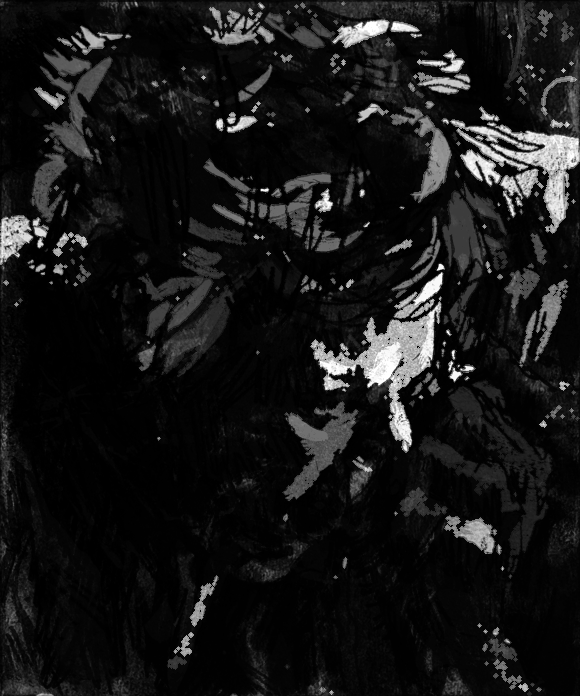

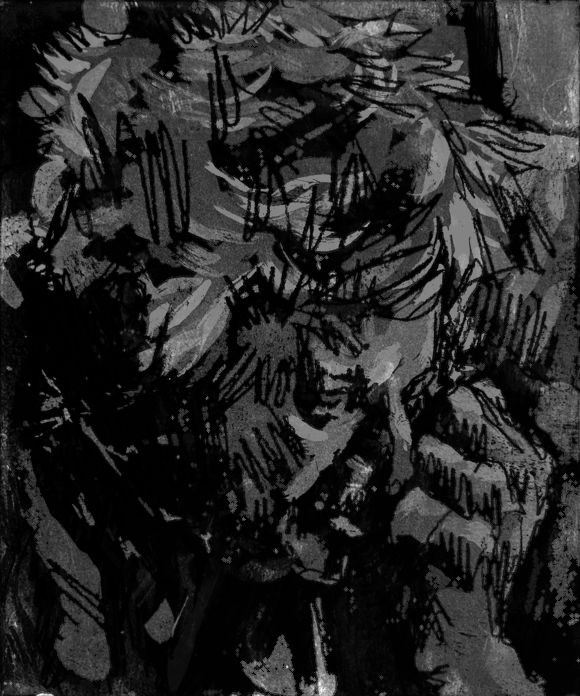

In [156]:
%matplotlib inline
display(frames15[0])
display(frames16[0])

In [ ]:
frames10 = []

advance_prob = 0.3

for i,f8 in enumerate(frames8):
    raven_im = raven_ims_use[raven_im_ind]
    thresh = threshold_otsu(np.asarray(raven_im))
    raven_im_inverted = ImageOps.invert(raven_im.copy())
    im_thresh = (np.asarray(raven_im_inverted) > thresh)
    grey_inds = np.where(im_thresh)
    
    f8_grey_array = np.array(f8.convert("L").convert("RGB"))
    frame_array = np.array(f8.copy())
    frame = Image.fromarray(frame_array)
    
    f8_grey = f8.convert("L")
    alpha = (1-np.array(f8_grey).astype(float)/255)**0.5
#
    raven_array = np.round( (1-alpha)*255 + alpha*np.array(raven_ims_use[raven_im_ind].copy()) ).astype(np.uint8)
    raven_im = Image.fromarray(raven_array)
    raven_im = g_to_mono(raven_im, (0.,0.,0.))
    

    #print(raven_im_ind, len(raven_ims_use)-1)
    if np.random.random()<advance_prob:
        raven_im_ind = raven_im_ind+1 if raven_im_ind<len(raven_ims_use)-1 else 0
        
    frames10.append(raven_im)


frames10 = [ImageChops.multiply(f10, f8) for (f10,f8) in zip(frames10,frames8)]

In [ ]:
%matplotlib inline

display(raven_im)

In [ ]:
v = VideoClip.DataVideoClip(frames4, im_to_frame_func(8), fps=20)
v.write_videofile("test.mp4")
#ipython_display(v, maxduration=4000)

In [ ]:
%matplotlib inline

num_frames=20

frames = []
i=0
reverse=False
while True:
    print(len(frames))
    if len(frames)==num_frames:
        break
    if reverse:
        if i>0:
            frames.append(ImageChops.multiply(soft_head_ims_brown[i], soft_head_ims_red[i-1]))
            frames.append(ImageChops.multiply(soft_head_ims_brown[i-1], soft_head_ims_red[i]))
            i -= 1
        else:
            i += 1
            reverse = False
    else:
        if i<len(soft_head_ims)-1:
            frames.append(ImageChops.multiply(soft_head_ims_brown[i], soft_head_ims_red[i+1]))
            frames.append(ImageChops.multiply(soft_head_ims_brown[i+1], soft_head_ims_red[i]))
            i += 1
        else:
            i -= 1
            reverse=True
        

anim = get_animation(supplement_ims(frames, combine_func = ImageChops.blend, combine_func_args={"alpha":0.5}), 
                     interval=400)
#HTML(anim.to_jshtml())

anim = get_animation(frames, interval=300)
HTML(anim.to_jshtml())

In [ ]:
frames_final = []

In [ ]:
new_carb_head_flicker_frames = {}

for i,c in enumerate(new_carb_head_ims):
    frames_grey, label_img = flicker_marks(c, 20, thresh_mult=1.)
    frames = [g_to_mono(im, rgb=(19, 99, 62), gamma=1.) for im in frames_grey]
    new_carb_head_flicker_frames[i] = frames

In [ ]:
print(new_carb_head_flicker_frames.keys())

In [ ]:
## frames1_fams is a list denoting which image in new_carb_head_frames a frames
#corresponds to
frames1,_,_,frames1_fams = mix_frames(new_carb_head_flicker_frames, 
               {0:(0.9,0.1,0.,0.,0.),
                1:(0.,0.9,0.1,0.,0.),
                2:(0.,0.,0.9,0.1,0.),
                3:(0.,0.,0.,0.9,0.1),
                4:(0.,0.,0.,0.1,0.9)},
               0.1,
               film_length=10., 
               end_after_fam=4,
              seed=1235, 
              verbose=True)



In [ ]:
frames1_zoom = get_sub_images(0.05, 0.3, 0.5, size, frames1)

In [ ]:
#frames2_grey = [ImageChops.multiply(f.convert("L"),fz.convert("L")) for (f,fz) in zip(frames1, frames1_zoom)]
#frames2_green = [g_to_mono(im, rgb=(19, 99, 62), gamma=1.) for im in frames2_grey]
frames2 = [ImageChops.multiply(f,fz) for (f,fz) in zip(frames1, frames1_zoom)]

%matplotlib inline
HTML(get_animation(frames1_zoom+frames2+frames1, interval=200, downsample=2).to_jshtml())

In [ ]:
soft_head_fades_1 = come_in_and_fade_out(soft_head_ims_brown[0], 5)

In [ ]:
frames3 = []
for i,f in enumerate(frames1):
    if i<len(soft_head_fades_1):
        frames3.append(ImageChops.multiply(f,soft_head_fades_1[i]))
    else:
        frames3.append(f)

%matplotlib inline
HTML(
    get_animation(
        supplement_ims(
            frames3, combine_func=ImageChops.blend, combine_func_args={"alpha":0.5}), downsample=2, interval=100
    ).to_jshtml())


In [ ]:
frames4 = []

lighten_fac=1
im_fam_current=-1
for i,f in enumerate(frames1):
    im_fam = frames1_fams[i]
    if im_fam == im_fam_current:
        lighten_fac = max(0., lighten_fac-0.2)
    else:
        lighten_fac = 1.
        im_fam_current = im_fam
    soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)
    frames4.append( ImageChops.multiply(f, soft_head_im) )

%matplotlib inline
HTML(
    get_animation(
        supplement_ims(
            frames4, combine_func=ImageChops.blend, combine_func_args={"alpha":0.5}), 
        interval=100, downsample=2
    ).to_jshtml()
)

In [ ]:
#Now introduce the soft red lines. we want these to enter for the next frames
frames5 = []

lighten_fac=1.
lighten_fac_red=1.
im_fam_current=-1
for i,f in enumerate(frames1):
    im_fam = frames1_fams[i]
    if im_fam == im_fam_current:
        lighten_fac = max(0., lighten_fac-0.2)
        lighten_fac_red = max(0., lighten_fac_red-0.2)
    else:
        lighten_fac = 1.
        ligten_fac_red = 1.
        im_fam_current = im_fam
    soft_head_im = lighten_im(soft_head_ims_brown[im_fam], lighten_fac)

    im_fam_red = im_fam+1 if (im_fam<4) else im_fam-1
    im_out = ImageChops.multiply(f, soft_head_im)
    if lighten_fac<0.5:
        soft_head_im_red = lighten_im(soft_head_ims_red[im_fam_red], lighten_fac_red)
        im_out = ImageChops.multiply(im_out, soft_head_im_red)
        
    frames5.append( im_out )

In [ ]:
%matplotlib inline
HTML(
    get_animation(
            frames5, 
        interval=200, downsample=2
    ).to_jshtml()
)

In [ ]:
#start with flickering

frames = []
num_flickers_per_im = 10
fade_facs = np.linspace(1.,0.,10)
frac_marks_use = 0.1
thresh_mult=1.

im_start = None
for i_carb,im_orig in enumerate(new_carb_head_ims):
    thresh = threshold_otsu(np.asarray(im_orig))
    im_grey = (im_orig.copy()).convert("L")
    im_grey_inverted = ImageOps.invert(im_grey.copy())
    im_thresh = (np.asarray(im_grey_inverted) > thresh*thresh_mult)
    Strel = morph.disk(2)
    im_thresh = morph.dilation(im_thresh,Strel)
    labels = np.arange(1,label_img.max())
    print(labels)

    flicker_frames_i = []
    for i_flicker in range(num_flickers_per_im): 
        labels_use = np.random.choice(labels, size=int(len(labels)*frac_marks_use+0.5),
                                     replace=False)
        im_new = im_grey.copy()
        #Might be easiest to do this with alpha channel
        alpha = np.ones(im_grey.size).astype(np.uint8).T
        for label in labels_use:
            alpha[np.where(label_img==label)] = 255
        alpha_frac = alpha.astype(float)/255
        im_new_array = np.round( (1-alpha_frac)*255 + alpha_frac*np.array(im_grey.copy()) ).astype(np.uint8)
        im_new = Image.fromarray(im_new_array)
        frames += [lighten_im(im_new, fade_fac) for fade_fac in fade_facs]
    break

frames = [g_to_mono(f, rgb=(19, 99, 62), gamma=1.) for f in frames]

In [ ]:
%matplotlib inline
HTML(get_animation(frames, interval=50, downsample=2).to_jshtml())

In [ ]:
## Just add reverse of sequence in general to image lists